再version 6的基础上，batchsize = 32， stem第一层变为4，用leaky relu，将inception a的函数里面的分支第一层神经元改为8

在Version 7的及基础上，加入L1正则化

In [1]:
# import zipfile

# f = zipfile.ZipFile("/root/Breast Cancer/Datasets Backup/40X.zip",'r') # 压缩文件在jupyter中的位置
# for file in f.namelist():
#     f.extract(file,"/root/Breast Cancer/Datasets")               # 解压到的位置
# f.close()

In [2]:
# !pip install scipy

In [3]:
# !pip install tensorflow-addons==0.18.0
# !pip install scikit-learn
# !pip install seaborn


In [4]:
# from tensorflow_addons.metrics import F1Score

In [5]:
# pip install numba


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Concatenate, DepthwiseConv2D, Multiply,
    Dropout, GlobalAveragePooling2D, Dense, MaxPooling2D, Flatten, Add, Reshape, AveragePooling2D
)
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
# Any additional code or custom layers you have can be added here.


In [2]:
input_shape = (224, 224, 3)

test_dir = '/root/Breast Cancer/Datasets/40XResized/test'
train_dir = '/root/Breast Cancer/Datasets/40XResized/train'


batch_size = 32
num_classes = 2
# filter_factor = 8

In [3]:
# train_BC = '/root/Breast Cancer/Datasets/40XResized/train/benign'

# #Show the import original image
# train_img_files = os.listdir(train_BC)
# # test_img_files = os.listdir(test_dir)
# # val_img_files = os.listdir(val_dir)

# show_num = 5

# plt.figure(figsize = (15, 5))

# for i in range(show_num):
    
#     img_path = os.path.join(train_BC, train_img_files[i])
#     img = plt.imread(img_path)
#     plt.subplot(1, show_num, i + 1)
#     plt.imshow(img)
#     plt.axis('on')
#     plt.title("Original Training Pic")
    
# plt.tight_layout()
# plt.show()


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: '/root/Breast Cancer/Datasets/40XResized/train/benign'

In [ ]:
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.13,  # Specify the validation split here
#     fill_mode='nearest'
# )
# test_datagen = ImageDataGenerator(rescale=1.0/255)

# # Load and preprocess the training and testing images
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=input_shape[:2],
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'  # Use 'training' subset for training data
# )

# validation_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=input_shape[:2],
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'  # Use 'validation' subset for validation data
# )

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=input_shape[:2],
#     batch_size=batch_size,
#     class_mode='categorical'
# )


In [ ]:
# #To show the augmented pictures, after rotation, zoom in, rescale etc

# # import scipy

# # Extract a batch of images from the train_generator
# sample_images, sample_labels = next(train_generator)

# plt.figure(figsize = (15, 5))

# # Show the original images from the batch
# num_images_to_show = 5  # Show three images
# for i in range(num_images_to_show):
#     plt.subplot(1, num_images_to_show, i + 1)
#     plt.imshow(sample_images[i-1])
#     plt.title("Augmented")
#     plt.axis('off')

In [4]:
# we reduce # filters by factor of 8 compared to original inception-v4
nb_filters_reduction_factor = 8

l2_reg = 0.001



def attention_block_2(x):
    # 使用卷积层创建一个更复杂的注意力机制
    attention_network = Conv2D(96, (3, 3), padding='same')(x)  # 增加卷积层
    attention_network = Activation('relu')(attention_network)
    attention_network = Conv2D(1, (1, 1), padding='same')(attention_network)  # 生成注意力图
    
    attention_output = Activation('sigmoid')(attention_network)
    scaled_feature = Multiply()([x, attention_output])  # 将注意力图应用于原始特征

    return scaled_feature

def inception_resnet_v2_stem(x):
    # Updated to use Conv2D and correct parameters
    x = Conv2D(32 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='leaky_relu',
               kernel_initializer='he_normal', padding='valid', kernel_regularizer = l2(l2_reg))(x)
    x = attention_block_2(x)
    x = Conv2D(32 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid', kernel_regularizer = l2(l2_reg))(x)
    x = attention_block_2(x)
    
    x = Conv2D(64 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same', kernel_regularizer = l2(l2_reg))(x)
    x = attention_block_2(x)
    

    a = MaxPooling2D((3, 3), strides=(1, 1), padding='valid')(x)
    b = Conv2D(96 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    x = Concatenate(axis=-1)([a, b])

    a = Conv2D(64 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # a = attention_block_2(x)
    
    a = Conv2D(96 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(a)
    # a = attention_block_2(x)
    
    b = Conv2D(64 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # b = attention_block_2(x)
    
    b = Conv2D(64 // nb_filters_reduction_factor, (7, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)
    
    b = Conv2D(64 // nb_filters_reduction_factor, (1, 7), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)
    
    b = Conv2D(96 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(b)
    # b = attention_block_2(x)
    
    x = Concatenate(axis=-1)([a, b])

    a = Conv2D(192 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    b = MaxPooling2D((3, 3), strides=(1, 1), padding='valid')(x)
    x = Concatenate(axis=-1)([a, b])

    x = Activation('relu')(x)
    
    return x

#Depthwise Changed
def inception_resnet_v2_A(x):
    shortcut = x
    
    a = Conv2D(128 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # a = attention_block_2(x)

    
    b = Conv2D(128 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # b = attention_block_2(x)

    b = DepthwiseConv2D((3, 3), strides=(1, 1), activation='relu',
                        kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)

    
    c = Conv2D(128 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # c = attention_block_2(x)

    # c = DepthwiseConv2D((3, 3), strides=(1, 1), activation='relu',
    #                     kernel_initializer='he_normal', padding='same')(c)
    c = Conv2D(64 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(c)
    # c = attention_block_2(x)

    
    x = Concatenate(axis=-1)([a, b, c])
    x = Conv2D(384 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

def inception_resnet_v2_reduction_A(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    b = Conv2D(384 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    c = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)    
    c = Conv2D(256 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(c)
    c = Conv2D(384 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(c)
    
    x = Concatenate(axis=-1)([a, b, c])
    
    return x
    

def inception_resnet_v2_B(x):
    shortcut = x
    
    a = Conv2D(192 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # a = attention_block_2(x)

    b = Conv2D(128 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # b = attention_block_2(x)

    b = Conv2D(160 // nb_filters_reduction_factor, (1, 7), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)

    b = Conv2D(192 // nb_filters_reduction_factor, (7, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)

    # b = DepthwiseConv2D((1, 7), strides=(1, 1), activation='relu',
    #                     kernel_initializer='he_normal', padding='same')(b)
    # b = DepthwiseConv2D((7, 1), strides=(1, 1), activation='relu',
    #                     kernel_initializer='he_normal', padding='same')(b)
    b = Conv2D(192 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)

    x = Concatenate(axis=-1)([a, b])
    x = Conv2D(1154 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_reduction_B(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    b = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    b = Conv2D(288 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(b)
    c = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    c = Conv2D(288 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(c)
    d = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    d = Conv2D(288 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(d)
    d = Conv2D(320 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(d)
    
    # d = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
    #            kernel_initializer='he_normal', padding='same')(x)
    # d = DepthwiseConv2D((3, 3), strides=(1, 1), activation='relu',
    #                     kernel_initializer='he_normal', padding='same')(d)
    # d = Conv2D(288 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
    #            kernel_initializer='he_normal', padding='same')(d)
    # d = Conv2D(320 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
    #            kernel_initializer='he_normal', padding='valid')(d)
    
    x = Concatenate(axis=-1)([a, b, c, d])
    
    return x


def inception_resnet_v2_C(x):
    shortcut = x
    
    a = Conv2D(192 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # a = attention_block_2(x)

    
    b = Conv2D(192 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # b = attention_block_2(x)

    b = Conv2D(224 // nb_filters_reduction_factor, (1, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)
    
    b = Conv2D(256 // nb_filters_reduction_factor, (3, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)

    
    x = Concatenate(axis=-1)([a, b])
    x = Conv2D(2048 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

In [5]:

# img_rows, img_cols = 32, 32
# img_channels = 3

# in original inception-resnet-v2, these are 5, 10, 5, respectively
num_A_blocks = 4
num_B_blocks = 5
num_C_blocks = 4

inputs = Input(shape=input_shape)

x = inception_resnet_v2_stem(inputs)
for i in range(num_A_blocks):
    x = inception_resnet_v2_A(x)
x = inception_resnet_v2_reduction_A(x)
for i in range(num_B_blocks):
    x = inception_resnet_v2_B(x)
x = inception_resnet_v2_reduction_B(x)
for i in range(num_C_blocks):
    x = inception_resnet_v2_C(x)

# x = AveragePooling2D(pool_size=(4, 4), strides=(1, 1), padding='valid')(x)
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

predictions = Dense(num_classes, activation='softmax', kernel_regularizer = l2(l2_reg))(x)

DIR = Model(inputs=inputs, outputs=predictions)
DIR.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 4)  112         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 222, 222, 96  3552        ['conv2d[0][0]']                 
                                )                                                                 
                                                                                              

                                )                                 'max_pooling2d_1[0][0]']        
                                                                                                  
 activation_6 (Activation)      (None, 214, 214, 48  0           ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 214, 214, 16  784         ['activation_6[0][0]']           
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 214, 214, 16  784         ['activation_6[0][0]']           
                                )                                                                 
          

 activation_9 (Activation)      (None, 214, 214, 48  0           ['add_2[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_33 (Conv2D)             (None, 214, 214, 16  784         ['activation_9[0][0]']           
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 214, 214, 16  784         ['activation_9[0][0]']           
                                )                                                                 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 214, 214, 16  784         ['activation_9[0][0]']           
          

                                )                                                                 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 106, 106, 24  3480        ['activation_11[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 106, 106, 24  600         ['conv2d_50[0][0]']              
                                )                                                                 
                                                                                                  
 concatenate_9 (Concatenate)    (None, 106, 106, 48  0           ['conv2d_47[0][0]',              
                                )                                 'conv2d_51[0][0]']              
          

 conv2d_65 (Conv2D)             (None, 106, 106, 24  3480        ['activation_14[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_69 (Conv2D)             (None, 106, 106, 24  600         ['conv2d_68[0][0]']              
                                )                                                                 
                                                                                                  
 concatenate_12 (Concatenate)   (None, 106, 106, 48  0           ['conv2d_65[0][0]',              
                                )                                 'conv2d_69[0][0]']              
                                                                                                  
 conv2d_70 (Conv2D)             (None, 106, 106, 14  7056        ['concatenate_12[0][0]']         
          

 conv2d_88 (Conv2D)             (None, 52, 52, 24)   6168        ['activation_17[0][0]']          
                                                                                                  
 conv2d_91 (Conv2D)             (None, 52, 52, 32)   2720        ['conv2d_90[0][0]']              
                                                                                                  
 concatenate_16 (Concatenate)   (None, 52, 52, 56)   0           ['conv2d_88[0][0]',              
                                                                  'conv2d_91[0][0]']              
                                                                                                  
 conv2d_92 (Conv2D)             (None, 52, 52, 256)  14592       ['concatenate_16[0][0]']         
                                                                                                  
 add_11 (Add)                   (None, 52, 52, 256)  0           ['activation_17[0][0]',          
          

In [13]:
# import numpy as np
# from sklearn.metrics import f1_score
# from tensorflow.keras.callbacks import Callback

# class F1ScoreCallback(Callback):
#     def __init__(self, train_generator, validation_generator, num_classes):
#         super(F1ScoreCallback, self).__init__()
#         self.train_generator = train_generator
#         self.validation_generator = validation_generator
#         self.num_classes = num_classes
#         self.train_f1_scores = []
#         self.val_f1_scores = []

#     def on_epoch_end(self, epoch, logs=None):
#         # 计算训练集F1分数
#         train_predict, train_true = self._get_predictions_and_true_labels(self.train_generator)
#         train_f1 = f1_score(train_true, train_predict, average='micro')
#         self.train_f1_scores.append(train_f1)
        
#         # 计算验证集F1分数
#         val_predict, val_true = self._get_predictions_and_true_labels(self.validation_generator)
#         val_f1 = f1_score(val_true, val_predict, average='micro')
#         self.val_f1_scores.append(val_f1)
        
#         print(f'Epoch {epoch+1}: Training F1 Score: {train_f1}, Validation F1 Score: {val_f1}')

#     def _get_predictions_and_true_labels(self, generator):
#         predictions = []
#         true_labels = []
#         for i in range(len(generator)):
#             x_batch, y_batch_true = next(generator)
#             y_batch_pred = self.model.predict(x_batch, verbose=0)
#             y_batch_pred = np.argmax(y_batch_pred, axis=1)
#             y_true = np.argmax(y_batch_true, axis=1)
#             predictions.extend(y_batch_pred)
#             true_labels.extend(y_true)
#         return predictions, true_labels


# # 继续使用之前的方式将回调添加到你的模型训练中


In [14]:
lr = 0.001
Optimizer = Adam(learning_rate = lr)

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import backend as K


DIR.compile(
    optimizer='adam',
    loss = "categorical_crossentropy",
    metrics=[
        "accuracy", 
        Precision(), 
        Recall(), 
        AUC(),
        F1Score(num_classes=2, average = 'micro')
    ]
)

MODEL_NAME = "Version8-DIR"  # 用您的模型名替换
# 训练合并后的模型
csv_logger = tf.keras.callbacks.CSVLogger(
    fr"/root/Breast Cancer/CSVHistory/{MODEL_NAME}.csv", 
    separator=",", 
    append=False)


lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', 
                                 factor = 0.1,
                                patience = 10,
                                min_lr = 0.00001,
                                verbose = 1)

# f1_score_callback = F1ScoreCallback(train_generator = train_generator, 
#                                     validation_generator=validation_generator, 
#                                     num_classes=num_classes)


from tensorflow.keras.callbacks import ModelCheckpoint

# 设置模型保存路径
model_checkpoint_path = "/root/Breast Cancer/Model Code/ModelFileH5/Version8-DIR.h5"

# 创建ModelCheckpoint回调，保存最佳模型
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_path,
    save_best_only=True,  # 仅保存在验证集上性能最好的模型
    monitor='val_loss',  # 监控的指标
    mode='min',  # 'min'意味着监控指标的最小值，'val_loss'减小意味着性能改善
    verbose=1  # 日志级别
)




In [15]:
history = DIR.fit(
    train_generator,
    epochs=150,  # 根据需要调整epochs数
    validation_data=validation_generator,
    callbacks=[csv_logger, lr_reduction, model_checkpoint_callback]  # 确保这里添加了model_checkpoint_callback
)


# history = DIR.fit(
#     train_generator,
#     epochs=150,
#     validation_data=validation_generator,
#     callbacks=[csv_logger, lr_reduction, model_checkpoint_callback, f1_score_callback]
# )


Epoch 1/150


2024-03-10 12:09:47.612750: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-03-10 12:09:48.618825: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-10 12:09:48.618845: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-10 12:09:48.618906: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-10 12:09:50.006876: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


71/71 [==============================] - ETA: 0s - loss: 28.0627 - accuracy: 0.5104 - precision: 0.5104 - recall: 0.5104 - auc: 0.5100 - f1_score: 0.5104
Epoch 1: val_loss improved from inf to 0.69737, saving model to /root/Breast Cancer/Model Code/ModelFileH5/Version8-DIR.h5
71/71 [==============================] - 67s 776ms/step - loss: 28.0627 - accuracy: 0.5104 - precision: 0.5104 - recall: 0.5104 - auc: 0.5100 - f1_score: 0.5104 - val_loss: 0.6974 - val_accuracy: 0.7544 - val_precision: 0.7544 - val_recall: 0.7544 - val_auc: 0.8093 - val_f1_score: 0.7544 - lr: 0.0010
Epoch 2/150
71/71 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.7022 - precision: 0.7022 - recall: 0.7022 - auc: 0.7696 - f1_score: 0.7022
Epoch 2: val_loss improved from 0.69737 to 0.51354, saving model to /root/Breast Cancer/Model Code/ModelFileH5/Version8-DIR.h5
71/71 [==============================] - 51s 720ms/step - loss: 0.6143 - accuracy: 0.7022 - precision: 0.7022 - recall: 0.7022 - 

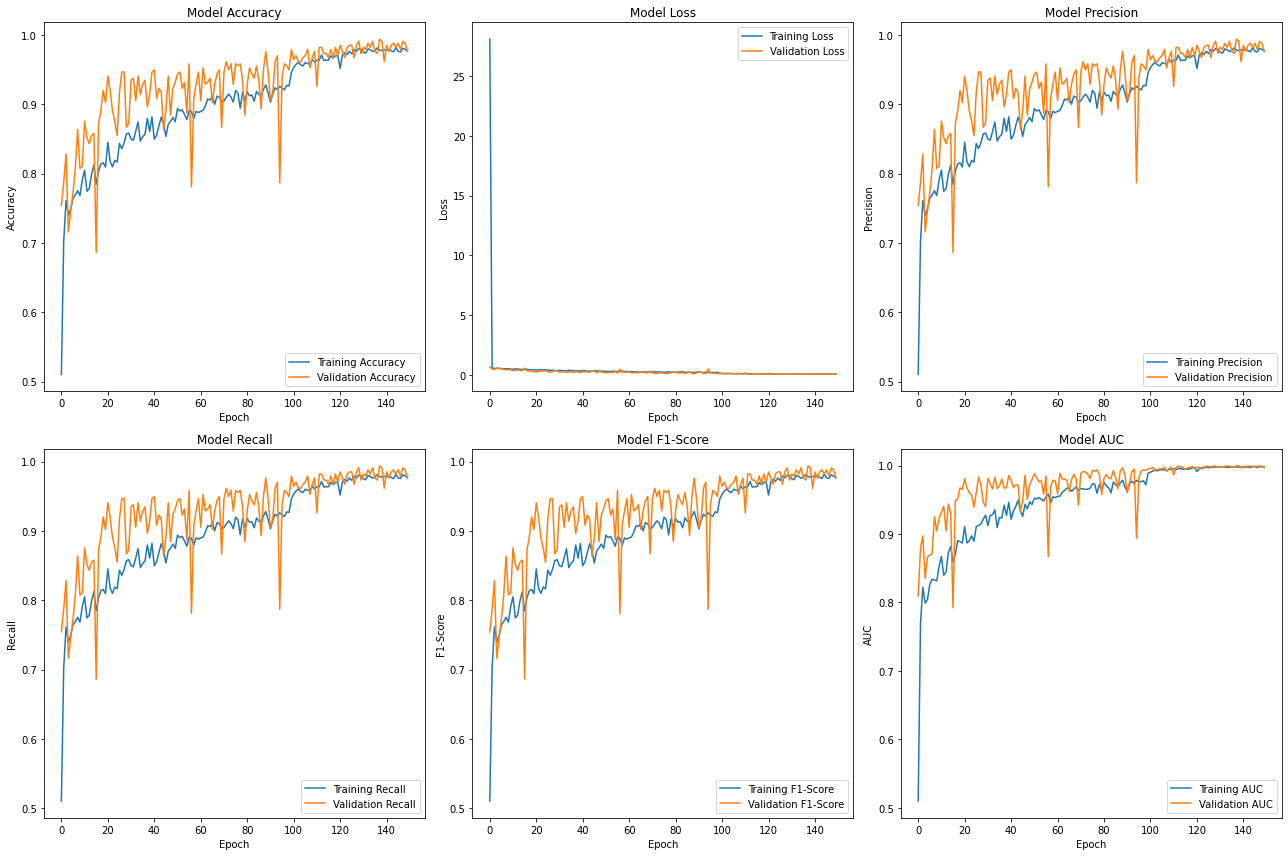

In [17]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.subplot(2, 3, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training Precision', 'Validation Precision'], loc='lower right')


plt.subplot(2, 3, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Recall', 'Validation Recall'], loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(['Training F1-Score', 'Validation F1-Score'], loc='lower right')

# plt.subplot(2, 3, 5)
# plt.plot(range(1, len(f1_score_callback.train_f1_scores) + 1), f1_score_callback.train_f1_scores, label='Training F1 Score')
# plt.plot(range(1, len(f1_score_callback.val_f1_scores) + 1), f1_score_callback.val_f1_scores, label='Validation F1 Score')
# plt.title('Model F1-Score')
# plt.xlabel('Epoch')
# plt.ylabel('F1-Score')
# plt.legend(['F1 Score'], loc='lower right')


plt.subplot(2, 3, 6)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training AUC', 'Validation AUC'], loc='lower right')

plt.tight_layout()
plt.show()

9/9 [==============================] - 2s 118ms/step


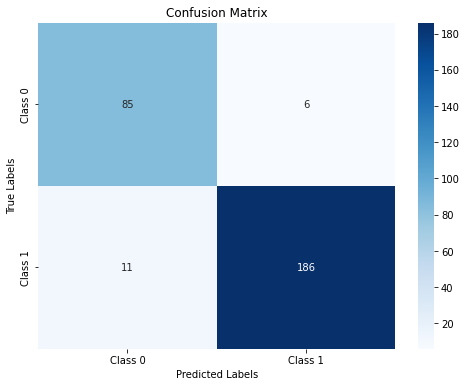

In [18]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 收集图像和真实标签
all_images, all_true_labels = zip(*[next(test_generator) for _ in range(test_generator.samples // test_generator.batch_size)])
all_images = np.concatenate(all_images)
all_true_labels = np.argmax(np.concatenate(all_true_labels), axis=1)

# 进行预测并获取预测标签
predictions = DIR.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# 生成并绘制混淆矩阵
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [19]:
from sklearn.metrics import f1_score


# 计算F1-Score
f1 = f1_score(all_true_labels, predicted_labels, average='macro')

print("F1-Score:", f1)


f1_each_class = f1_score(all_true_labels, predicted_labels, average=None)
print("F1-Score for each class:", f1_each_class)


F1-Score: 0.932694554802524
F1-Score for each class: [0.90909091 0.9562982 ]


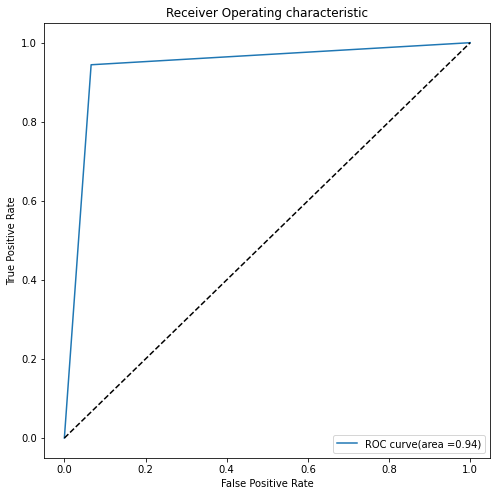

In [20]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(all_true_labels, predicted_labels)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [21]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.9441624365482234
specificity: 0.9340659340659341


9/9 [==============================] - 1s 116ms/step


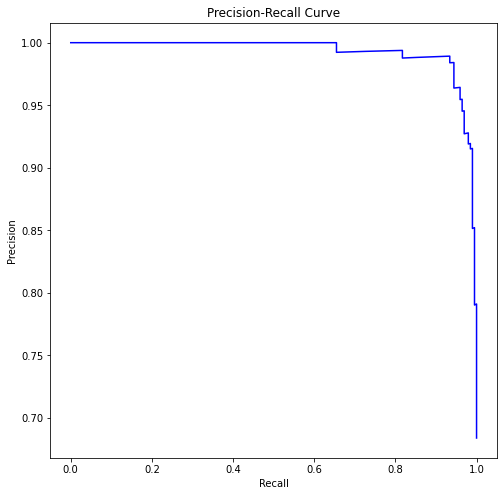

In [22]:
from sklearn.metrics import precision_recall_curve

# 计算预测概率
ensemble_pred_probs =  DIR.predict(all_images)

# 获取预测正类的概率
# 假设是二分类问题，并且正类是第二个类别
positive_class_probs = ensemble_pred_probs[:, 1]

# 计算 Precision 和 Recall
precision, recall, thresholds = precision_recall_curve(all_true_labels, positive_class_probs)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [24]:
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1_score = DIR.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test AUC:', test_auc)
print('Test F1 Score:', test_f1_score)

# test_loss, test_acc, test_precision, test_recall, test_auc = DIR.evaluate(test_generator)
# print('Test loss:', test_loss)
# print('Test accuracy:', test_acc)
# print('Test precision:', test_precision)
# print('Test recall:', test_recall)
# print('Test AUC:', test_auc)


# from sklearn.metrics import f1_score
# import numpy as np

# # 预测测试集
# y_pred = DIR.predict(test_generator)
# y_pred = np.argmax(y_pred, axis=1)

# # 真实标签
# y_true = test_generator.classes

# # 计算F1分数
# test_f1_score = f1_score(y_true, y_pred, average='micro')  # 或者根据你的需要选择其他average参数
# print('Test F1 Score:', test_f1_score)


10/10 [==============================] - 1s 117ms/step - loss: 0.2500 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9833 - f1_score: 0.9435
Test loss: 0.2500014901161194
Test accuracy: 0.9435216188430786
Test precision: 0.9435216188430786
Test recall: 0.9435216188430786
Test AUC: 0.9833444952964783
Test F1 Score: 0.9435216188430786


In [25]:
from sklearn.metrics import classification_report

# 使用模型对验证集进行预测，获取预测概率
y_pred_probs = DIR.predict(all_images)

# 将预测概率转换为类别标签
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 假设 y_val 是真实标签，并且也是类别标签形式
# 现在您可以生成分类报告
report = classification_report(all_true_labels, y_pred_labels)
print(report)


9/9 [==============================] - 1s 119ms/step
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        91
           1       0.97      0.94      0.96       197

    accuracy                           0.94       288
   macro avg       0.93      0.94      0.93       288
weighted avg       0.94      0.94      0.94       288



#delete the model to prevent memory costs

from keras import backend as K
import gc

K.clear_session()
gc.collect()

# del DIR


from numba import cuda

cuda.select_device(0)
cuda.close()